<a href="https://colab.research.google.com/github/Dennis-Bersenev/BasicPathTracer/blob/master/bulk_multiomics_zs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enviro Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specifically for Google Colab, install dependencies and download data

import os
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")
    !pip install -U scgpt
    # the optional dependency of flash-attion is skipped on colab
    !pip install wandb louvain faiss-cpu
    # !pip install flash-attn==0.2.4
    # NOTE: May need to restart runtime after the installation

    !pip install -q -U gdown
    import gdown

    data_dir = "../../data"
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)


Running on Google Colab
Installing dependencies...
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

## Import scGPT and dependencies

In [ ]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
#from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
wandb.login(key="a2259c02c43a7b1f6b915093bf7ac0ccbb0ddfa1")

from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
import pandas as pd
import scipy.sparse as sp
from sklearn import preprocessing

sys.path.insert(0, "../")
from scgpt import prepare_data, prepare_dataloader, define_wandb_metrcis, evaluate, eval_testdata, train
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.model import MultiOmicTransformerModel

import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.tokenizer import random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIIm

In [ ]:
# Use the pretrained model
print("Downloading model ckpt...")
model_dir = "../../save/scGPT_human"
if not os.path.exists(model_dir):
    !mkdir -p $model_dir
    gdown.download_folder(
        "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
        output=model_dir,
    )

Retrieving folder contents


Processing file 1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1 args.json
Processing file 14AebJfGOUF047Eg40hk57HCtrb0fyDTm best_model.pt
Processing file 1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC vocab.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1hh2zGKyWAx3DyovD30GStZ3QlzmSqdk1
To: /save/scGPT_human/args.json
100%|██████████| 1.30k/1.30k [00:00<00:00, 1.68MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm
From (redirected): https://drive.google.com/uc?id=14AebJfGOUF047Eg40hk57HCtrb0fyDTm&confirm=t&uuid=106f0f79-664f-413c-a6cc-b04ae95ad4f5
To: /save/scGPT_human/best_model.pt
100%|██████████| 205M/205M [00:02<00:00, 102MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1H3E_MJ-Dl36AQV6jLbna2EdvgPaqvqcC
To: /save/scGPT_human/vocab.json
100%|██████████| 1.32M/1.32M [00:00<00:00, 125MB/s]
Download completed


Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [ ]:
# settings for input and preprocessing
special_tokens = ["<pad>", "<cls>", "<eoc>"]

dataset_name = "bulk_multiome"
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_bulk_multiome-Oct07-03-57


# Evals Helpers

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import scib

In [ ]:
"""
Calculate the metrics for integration results
"""
def scib_eval(adata, batch_key, cell_type_key, embed_key):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=cell_type_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()

    # compute avgBIO metrics
    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )

    # compute avgBATCH metrics
    result_dict["avg_batch"] = np.mean(
        [
            result_dict["graph_conn"],
            result_dict["ASW_label/batch"],
        ]
    )

    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}

    return result_dict

# Data Processing

In [ ]:
# For the ScMultiomic dataset
data_path = '/content/drive/My Drive/multiomic_data'
adata_rna = sc.read(os.path.join(data_path, 'normalized_paired_rna.h5ad'))
adata_protein = sc.read(os.path.join(data_path, 'raw_abundance_metadata_2.h5ad'))


In [ ]:
# NOTE: undoing log2 norm and replacing with log1p
temp_X = adata_rna.X
adata_rna.X = 2 ** temp_X

In [ ]:
gene_col = "gene_name"
cell_type_key = "tissue_ID"
batch_key = "donor_ID"
N_HVG = 300
data_is_raw = True
n_bins = 51

In [ ]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=1,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=N_HVG,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata_rna, batch_key=None)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


In [ ]:
preprocessor_protein = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor=None,
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_protein(adata_protein, batch_key=None)

scGPT - INFO - Binning data ...


#### My custom concatenation approach

In [ ]:
var = pd.DataFrame(index=adata_rna.var['gene_name'].to_list() + adata_protein.var['gene_name'].to_list())
var["gene_name"] = var.index.tolist()
var = var.reset_index(drop=True)
num_rows = adata_rna.X.shape[0]
num_cols = adata_rna.X.shape[1] + adata_protein.X.shape[1]
X = np.zeros((num_rows, num_cols))
bins = X


In [ ]:
donor_ids = []
tissue_ids = []
tissues = []
for idx, row in adata_rna.obs.iterrows():
    # print(f'index: {idx}')
    # print(f'row:\n{row}')

    # Getting the matching row from the protein dataframe
    donor = row.iloc[1]
    tissue = row.iloc[2]
    tissue_name = row.iloc[3]

    res = adata_protein.obs.loc[(adata_protein.obs['donor_ID'] == donor) & (adata_protein.obs['tissue_ID'] == tissue)]
    # print(res)
    i = int(res.index.values[0])

    # Concatenating rows
    rX = adata_rna.X[int(idx)]
    pX = adata_protein.X[i]
    cX = np.concatenate([rX, pX])
    X[int(idx), :] = cX

    r_bins = adata_rna.layers["X_binned"][int(idx)]
    p_bins = adata_protein.layers["X_binned"][i]
    c_bins = np.concatenate([r_bins, p_bins])
    bins[int(idx), :] = c_bins


    donor_ids.append(donor)
    tissue_ids.append(tissue)
    tissues.append(tissue_name)


In [ ]:
import anndata as ad

In [ ]:
obs = pd.DataFrame({
    'donor_ID': donor_ids,
    'tissue_ID': tissue_ids,
    'tissue_micro': tissues
})

adata = ad.AnnData(X=X, obs=obs, var=var)
adata.layers['X_binned'] = bins

# Actual Evaluation

In [ ]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64
)
# attach the cell embedding to the original adata

scGPT - INFO - match 12376/12734 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


In [ ]:
embed_adata

AnnData object with n_obs × n_vars = 182 × 12376
    obs: 'donor_ID', 'tissue_ID', 'tissue_micro'
    var: 'gene_name', 'id_in_vocab'
    obsm: 'X_scGPT'
    layers: 'X_binned'

In [ ]:
# TODO: some renaming for all these plots!

In [ ]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)

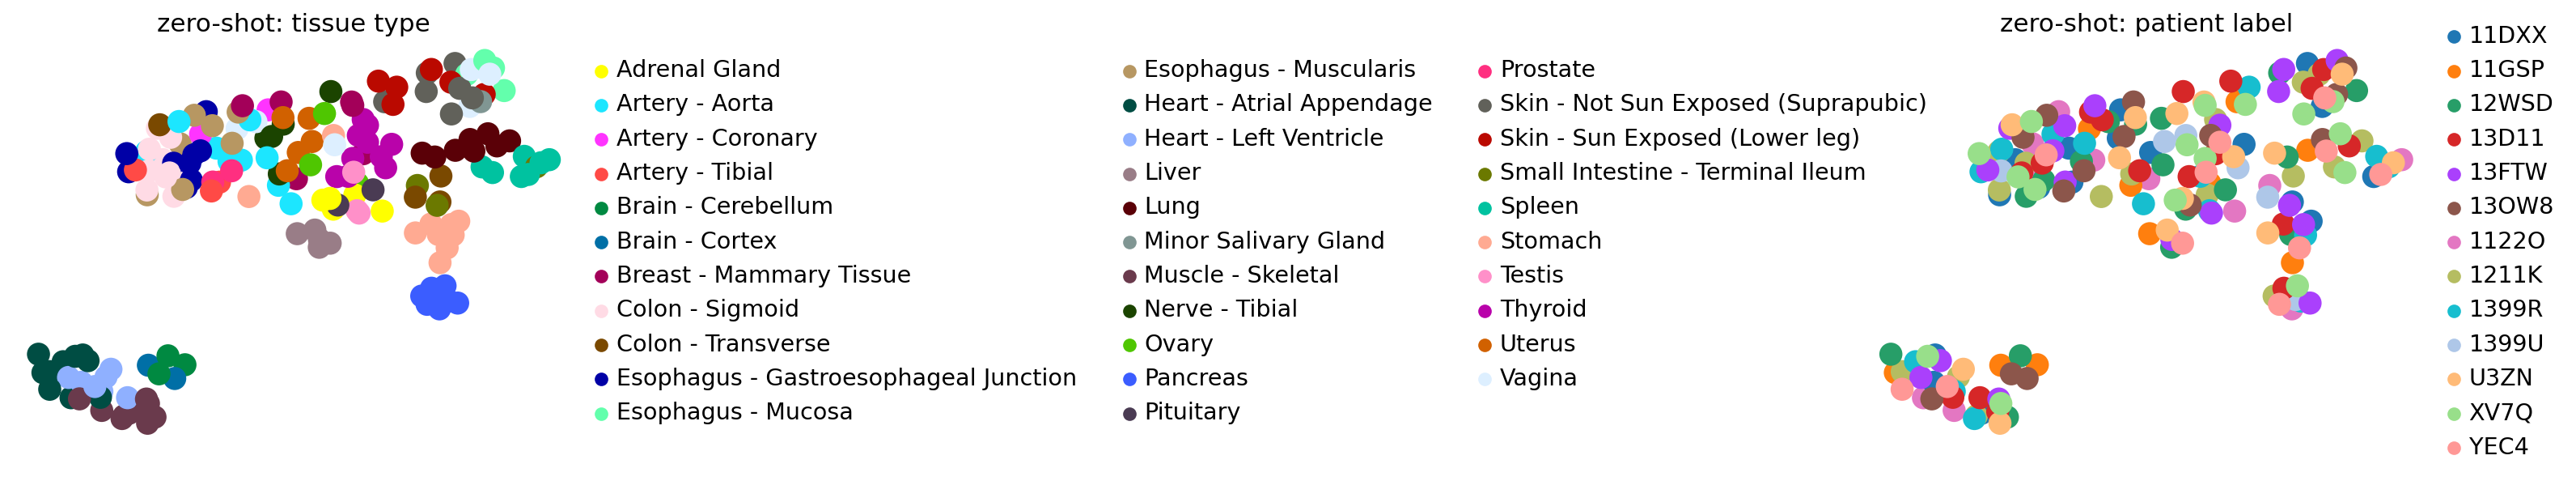

In [ ]:
sc.pl.umap(embed_adata,
           color=['tissue_micro', batch_key],
           frameon=False,
           wspace=2.0,
           title=["zero-shot: tissue type", "zero-shot: patient label"])

In [ ]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)

NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...


In [ ]:
scib_result_dict

{'NMI_cluster/label': 0.29191156186302086,
 'ARI_cluster/label': 0.008916996930420728,
 'ASW_label': 0.4150368794798851,
 'PCR_batch': 0.18485709636105047,
 'graph_conn': 0.416282242063492,
 'avg_bio': 0.23862181275777558}

In [ ]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))

AvgBIO: 0.2386
